# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 мая 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 мая, -4 балла после 06:00 13 мая, -6 баллов после 06:00 20 мая -8 баллов  после 06:00 27 мая


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [399]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance
from collections import deque
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import f1_score

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda3/envs/pt1p36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



### Решение: $k^N$ - это верхняя оценка количеста вариантов разбиения $N$ объектов по $K$ кластерам (хотя эта оценка немного завышена). Т.е. количество возможных разбиений конечно.

Можно доказать, что на каждом шаге переназначения центроидов кластеров функционал стоимости снижается, т.е. минимизируемый функционал стоимости является монотонно убывающей функцией.

Более того, очевидно, что если на каком-то этапе переназначения не произошло, то на этом структура кластеров фиксируется и дальнейшних изменений не происходит, т.е. процесс сошёлся.

Из этих двух факторов следует, что процесс сходится за конечное время. Надо отметить, что процесс сходится в общем случае к локальному минимуму, т.к. функционал не является выпуклой функцией.

Задача 2. Сходимость EM.

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



### Решение: распределение должно удовлетворять условию гладкости. Должна существовать стационарная точка правдоподобия.

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчёта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




### Решение: попробую для таких простых случаев обойтись без формул. 

Для single linkage модуль раскрывается либо как $d_{\min}(U, S) - d_{\min}(V, S) $, либо как $d_{\min}(V, S) - d_{\min}(U, S) $ в зависимости от того, какой кластер "ближе" к S. После раскрытия модуля у нас два члена из суммы уничтожаются и остаются $1/2 + 1/2 = 1 * \min[d_{\min}(V, S), d_{\min}(U, S)]$ (бОльшие значения при раскрытии модуля
сокращаются, меньшие остаются), что и соответствует определению single linkage, посколько после объединения элементов двух кластеров наименьшее расстояние от элемента этого кластера до кластера $S$ есть мера расстояния в соответствии с single linkage.

Рассмотрим один пример для наглядности: 
пусть $d_{\min}(U, S) < d_{\min}(V, S)$, тогда $d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} d_{\min}(V, S) + \frac{1}{2} d_{\min}(U, S) = d_{\min}(U, S) $

Второй случае аналогичен.

Для complete linkage аналогично, но перед модулем стоит знак + и мы получаем после раскрытия сокращение двух других членов, в результате получаем $\max[d_{\max}(V, S), d_{\max}(U, S)]$, что соответствует определению complete linkage для кластера, включающего все элементы и $V,  U$.


# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [289]:
from sklearn.base import BaseEstimator, ClusterMixin

class Cluster():
    def __init__(self, left=None, right=None, element=None, distance=None, depth=0, pn=-1, cluster_id=-1):
        self.left = left
        self.right = right
        self.depth = depth
        self.point_number = pn
        self.cluster_id = cluster_id
        
        if left is not None:
            self.left = left
            self.right = right
            self.elements = np.vstack([left.elements, right.elements])

        if element is not None:
            self.elements = element
            self.elements = np.expand_dims(self.elements, 0)

        self.centroid = np.mean(self.elements, axis=0)
        self.distance = distance
        
class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, metric, n_clusters=None, **kwargs):
        """
        metric - string with name of metric, for example, euclidean
        Please add necessary algoritm parameters to class constructor.
        """
        self.n_clusters = n_clusters or 1 # int(1e10)
        self.metric = metric

    def min_dist(self, cl1, cl2):
        _dists = distance.cdist(cl1.elements, cl2.elements, 'euclidean')
        #idx = np.unravel_index(np.argmin(_dists), _dists.shape)
        return np.min(_dists) #_dists[idx]
    
    def max_dist(self, cl1, cl2):
        _dists = distance.cdist(cl1.elements, cl2.elements, 'euclidean')
        # idx = np.unravel_index(np.argmax(_dists), _dists.shape)
        return np.max(_dists) # _dists[idx]
    
    def cl_dist(self, cl1, cl2, dist_method=None):
        return numpy.linalg.norm(cl1.centroid - cl2.centroid)
        
    def fit_predict(self, x):
        """
        Use data matrix x to compute model parameters and predict clusters
        """
        self.autoincrement = len(x)
        self.x = x # TODO!!! переделать, чтобы не сохранять ссылку на данные
        self.x_len = len(x)
        self.clusters = []
        self.clusters_list = []
        
        # init base clusters
        for _pos, _x in enumerate(x):
            # print(np.expand_dims(_x, 0), x)
            # по идее на этапе инициализации все значения будут идентичными!!! TODO Можно переделать.
            # а можно оставить - сейчас получается двойное вычисление 
            _dist_matrix = distance.cdist(np.expand_dims(_x, 0), np.delete(x, _pos, axis=0), 'euclidean')
            if self.metric == 'single':
                _dist_cluster = np.min(_dist_matrix)
            elif self.metric == 'complete':
                _dist_cluster = np.max(_dist_matrix)
            else:
                _dist_cluster = np.mean(_dist_matrix)
                
            self.clusters.append(Cluster(element=_x, distance=_dist_cluster, depth=0, pn=_pos, cluster_id=_pos))
        
        # fit data - build clusters tree 
        cl_to_join = self.clusters
        while len(cl_to_join) > self.n_clusters: # 1 : # пока не сведём всё в один кластер
            
            # ищем ближайшие (доработка)
            
            min_dist = int(1e10)
            cl1 = None
            cl2 = None
            
            # перебираем, пока не придумал как лучше сделать, потому что количество точек разные и попарно не получается
            # сделать
            for _cl1_pos, _cl1 in enumerate(cl_to_join[:-1]):
                #print("_cl1 pos", _cl1_pos)
                for _cl2_pos, _cl2 in enumerate(cl_to_join[_cl1_pos + 1:]):
                    #print("_cl2 pos", _cl2_pos)
                    if self.metric == 'single':
                        _dist = self.min_dist(_cl1, _cl2)
                        a = 0.5
                        b = 0
                        c = -0.5
                    elif self.metric == 'complete':
                        _dist = self.max_dist(_cl1, _cl2)
                        a = 0.5
                        b = 0
                        c = 0.5
                    elif self.metric == 'centroid':
                        _dist = self.cl_dist(_cl1, _cl2)
                        new_dist = _dist
                    else: # average
                        _dist = np.mean(_dist_matrix)

                    if _dist < min_dist:
                        cl1 = _cl1
                        cl2 = _cl2
                        min_dist = _dist
            
            # Используем формулы Ланса-Вильямса для сокращения размера кода
            if self.metric != 'centroid':
                new_dist = a * (cl1.distance + cl2.distance) + c * np.abs(cl1.distance - cl2.distance)
                #print(new_dist)
                    
            # join and delete from list
            # print(f"cl1, cl2", len(cl1.elements), len(cl2.elements))
            cl_to_join.append(Cluster(left=cl1, right=cl2, distance=new_dist, depth=max(cl1.depth, cl2.depth) + 1, cluster_id=self.autoincrement)) # добавим новый и удалим два объединенных
            
            self.clusters_list.append((cl1.cluster_id, cl2.cluster_id, new_dist, len(cl1.elements) + len(cl2.elements), self.autoincrement))
            
            self.autoincrement += 1
            cl_to_join.remove(cl1)
            cl_to_join.remove(cl2)
            
            # print(cl1.elements, cl2.elements, min_dist)

        # обновимся
        # print(len(cl_to_join))
        self.clusters = cl_to_join 
        
        if True: # self.metric == 'centroid':
            centroids = []
            for _cl in self.clusters:
                centroids.append(_cl.centroid)

            _centr_arr = np.vstack(centroids)
            preds = np.argmin(distance.cdist(x, _centr_arr, 'euclidean'), axis=1) # np.random.randint(1, size=len(x)) # preds = [1] * len(x) #np.argmin(distance.cdist(x, _centr_arr, 'euclidean'), axis=1)
        else:  
            # сделаем хэш-массив с мэппингом элементов на кластеры, к которым они отностся
            # найти ближайшую точку и по ней выбрать кластер
            points_map = {}
            for _clnum, _cl in enumerate(self.clusters):
                for _el in _cl.elements:
                    #print(_el)
                    points_map[tuple(_el)] = _clnum
            
            # preds = np.argmin(distance.cdist(x, x, 'euclidean'), axis=1)
            preds = np.array([points_map[tuple(_x)] for _x in x])
                
        return preds
    
    
    def printTree(self, root_node):
        """
        Print tree for one root_node
        """
        
        self.treedict = defaultdict(list)
        
        if root_node is None:
            return
        else:
            curr = root_node
            q = deque()
            q.append(curr)
            
            while (len(q) > 0):
                curr = q.popleft()
                self.treedict[curr.depth].append(curr)
                # print(len(curr.elements), len(q))
                
                if not (curr.left is None):
                    print(len(curr.elements), len(curr.left.elements), len(curr.right.elements), self.min_dist(curr.left, curr.right), "Depth", curr.depth)
                    #print("Left", curr.left.elements)
                    #print("Right", curr.right.elements)
                if not (curr.left is None):
                    q.append(curr.left)
                if not (curr.right is None):
                    q.append(curr.right)
                    
    def printTree2(self, root_node):
        """
        Print tree for one root_node
        """
        
        self.treedict = defaultdict(list)
        
        if root_node is None:
            return
        else:
            curr = root_node
            q = deque()
            q.append(curr)
            
            while (len(q) > 0):
                curr = q.popleft()
                self.treedict[curr.depth].append(curr.elements)
                # print(len(curr.elements), len(q))
                
                if not (curr.left is None):
                    print(len(curr.elements), len(curr.left.elements), len(curr.right.elements), self.min_dist(curr.left, curr.right), "Depth", curr.depth)
                    #print("Left", curr.left.elements)
                    #print("Right", curr.right.elements)
                if not (curr.left is None):
                    q.append(curr.left)
                if not (curr.right is None):
                    q.append(curr.right)
                    

    
    def plot_dendrogram(self):
        """
        Try to visualize our data
        """
        pass

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

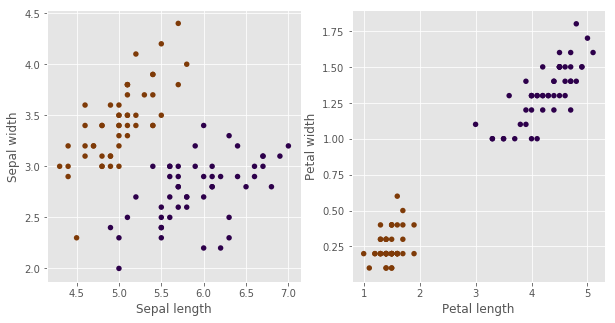

In [5]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [194]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

 Sklearn AGGL score 1.0. Sklearn AGGL time 0.09037017822265625


In [343]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering(n_clusters=2, metric='complete') # , metric='single' # metric='centroid'
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))

Our AGGL score 1.0. Our AGGL time 3.4958808422088623


In [ ]:
### Единичный скор получается на любой из трех реализованных метрик

In [364]:
cluster_1 = Clustering(n_clusters=1, metric='complete')
aggl_pred = cluster_1.fit_predict(x_iris)
#aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
#print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))

In [365]:
len(cluster_1.clusters_list) 
draw_list = sorted(cluster_1.clusters_list, key=lambda x: x[3])

In [366]:
# список для построения дендрограмм - посмотрим глазами
draw_list

[(7, 39, 4.189272013130682, 2, 100),
 (0, 17, 4.244997055358226, 2, 101),
 (9, 34, 4.249705872175156, 2, 102),
 (10, 48, 4.117037770047782, 2, 103),
 (4, 37, 4.37264222181509, 2, 104),
 (19, 21, 4.172529209005013, 2, 105),
 (29, 30, 4.224926034855521, 2, 106),
 (57, 93, 2.9291637031753615, 2, 107),
 (80, 81, 3.3015148038438356, 2, 108),
 (8, 38, 4.60760241340331, 2, 109),
 (3, 47, 4.433959855479072, 2, 110),
 (27, 28, 4.197618372363071, 2, 111),
 (82, 92, 3.5270384177096803, 2, 112),
 (95, 96, 3.6262928728937496, 2, 113),
 (1, 45, 4.304648650006177, 2, 114),
 (63, 91, 4.230839160261235, 2, 115),
 (65, 75, 4.283689998120779, 2, 116),
 (94, 99, 3.6414282912066254, 2, 119),
 (66, 84, 3.911521443121589, 2, 121),
 (23, 26, 4.03732584763727, 2, 122),
 (53, 89, 3.5651086939951777, 2, 125),
 (74, 97, 4.012480529547776, 2, 126),
 (54, 58, 4.369210454990695, 2, 127),
 (68, 87, 4.296510211788168, 2, 131),
 (50, 52, 4.813522618623496, 2, 135),
 (51, 56, 4.39317652729776, 2, 136),
 (20, 31, 3.97366

In [367]:
cluster_1.printTree(cluster_1.clusters[0]);

100 50 50 1.6401219466856727 Depth 11
50 29 21 0.22360679774997858 Depth 10
50 12 38 0.2645751311064592 Depth 10
29 1 28 0.6244997998398398 Depth 9
21 5 16 0.3464101615137753 Depth 6
12 4 8 0.6480740698407862 Depth 6
38 15 23 0.2645751311064587 Depth 9
28 19 9 0.17320508075688812 Depth 8
5 3 2 0.3605551275463992 Depth 3
16 7 9 0.2449489742783178 Depth 5
4 1 3 0.3605551275463989 Depth 3
8 2 6 0.3464101615137758 Depth 5
15 9 6 0.31622776601683755 Depth 5
23 3 20 0.4898979485566356 Depth 8
19 8 11 0.24494897427831747 Depth 7
9 1 8 0.45825756949558394 Depth 6
3 1 2 0.3872983346207418 Depth 2
2 1 1 0.5477225575051664 Depth 1
7 2 5 0.3464101615137753 Depth 4
9 4 5 0.31622776601683794 Depth 4
3 1 2 0.3872983346207412 Depth 2
2 1 1 0.44721359549995804 Depth 1
6 1 5 0.38729833462074165 Depth 4
9 5 4 0.31622776601683783 Depth 4
6 2 4 0.6244997998398397 Depth 3
3 1 2 0.5916079783099617 Depth 2
20 4 16 0.26457513110645914 Depth 7
8 2 6 0.14142135623730995 Depth 4
11 1 10 0.22360679774997877 Depth 

In [368]:
level = 0
points = []
for cl in cluster_1.treedict[level]:
    # print(cl.point_number)
    points.append(cl.point_number)
points_arr = np.array(points)

len(points_arr), points_arr

(100,
 array([41, 60, 22, 16, 14, 15, 98, 64, 79, 59, 62, 35, 32, 33,  5, 18, 44,
        57, 93, 77, 72, 83, 68, 87, 29, 30,  6, 13, 20, 31, 36, 46, 43, 11,
        24, 53, 89, 69, 65, 75, 76, 86, 51, 56, 70, 85, 66, 84, 55, 90, 25,
        12,  4, 37, 42,  8, 38, 10, 48, 19, 21, 23, 26, 80, 81, 54, 58, 50,
        52, 74, 97, 73, 61, 71,  9, 34,  1, 45, 27, 28,  2, 78, 67, 40, 49,
         3, 47, 63, 91, 82, 92, 94, 99, 88,  0, 17,  7, 39, 95, 96]))

In [369]:
X_coords = {}
for pos, cln in enumerate(points_arr):
    X_coords[cln] = (pos, 0)

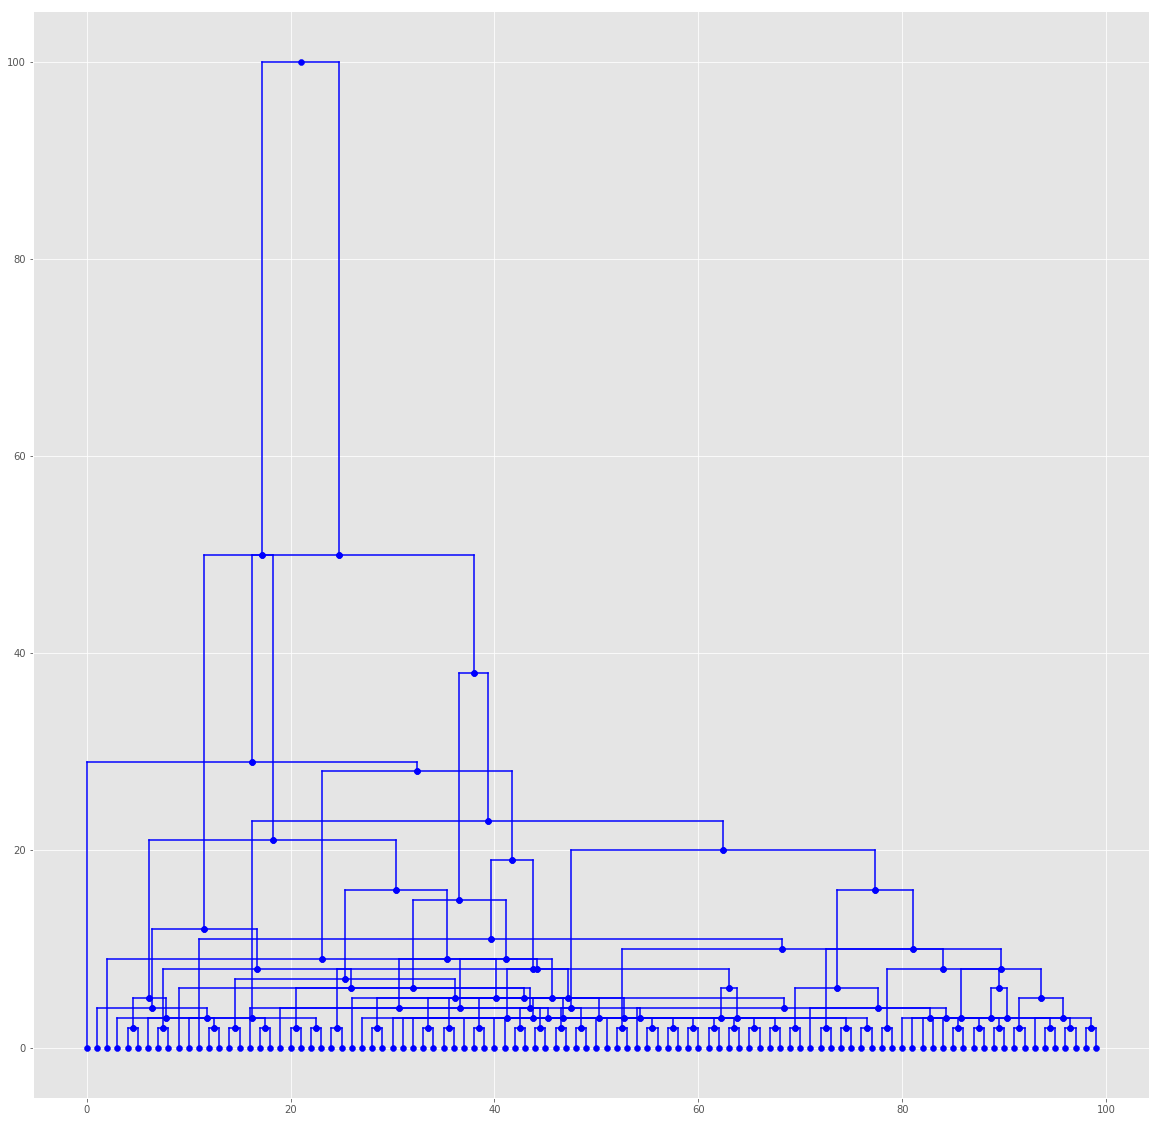

In [370]:
# построим дендрограмму дерева

plt.figure(figsize=(20, 20))
for item in draw_list:
    x1, y1 = X_coords[item[0]]
    x2, y2 = X_coords[item[1]]
    _dist = item[2]
    numitems = item[3]
    new_cl = item[4]
    
    new_x = (x1 + x2) / 2
    new_y = numitems # _dist # numitems
    
    X_coords[new_cl] = (new_x, new_y)
    plt.scatter(x1, y1, color='blue')
    plt.scatter(x2, y2, color='blue')
    plt.scatter(new_x, new_y, color='blue')
    
    plt.plot([x1, x1], [y1, new_y], color='blue')
    plt.plot([x2, x2], [y2, new_y], color='blue')
    
    plt.plot([x1, x2], [new_y, new_y], color='blue')

In [ ]:
# что-то с дендрограммой не то - либо нарушены условия монотонности в алгоритме кластеризации, либо некорректная отриосвка

In [212]:
сustum_aggl.printTree2(сustum_aggl.clusters[0])

50 1 49 0.6244997998398398 Depth 24
49 1 48 0.45825756949558394 Depth 23
48 1 47 0.412310562561766 Depth 22
47 1 46 0.3605551275463992 Depth 21
46 1 45 0.3605551275463988 Depth 20
45 43 2 0.3464101615137755 Depth 19
43 2 41 0.3464101615137753 Depth 18
2 1 1 0.3464101615137755 Depth 1
2 1 1 0.33166247903553986 Depth 1
41 1 40 0.3464101615137753 Depth 17
40 2 38 0.3000000000000001 Depth 16
2 1 1 0.282842712474619 Depth 1
38 1 37 0.3 Depth 15
37 1 36 0.2999999999999998 Depth 14
36 1 35 0.244948974278318 Depth 13
35 3 32 0.2449489742783178 Depth 12
3 1 2 0.14142135623730953 Depth 2
32 16 16 0.22360679774997916 Depth 11
2 1 1 0.14142135623730928 Depth 1
16 1 15 0.22360679774997871 Depth 10
16 3 13 0.22360679774997902 Depth 8
15 1 14 0.22360679774997858 Depth 9
3 1 2 0.22360679774997896 Depth 2
13 2 11 0.22360679774997896 Depth 7
14 11 3 0.22360679774997827 Depth 8
2 1 1 0.1999999999999998 Depth 1
2 1 1 0.10000000000000053 Depth 1
11 1 10 0.22360679774997877 Depth 6
11 3 8 0.1732050807568881

In [161]:
points = []
for cl in сustum_aggl.treedict[0]:
    # print(cl.point_number)
    points.append(cl.point_number)
sorted(points)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

In [175]:
for cl in сustum_aggl.treedict[1]:
    print(cl.left.point_number, cl.right.point_number)

32 33
5 18
20 31
19 21
23 26
10 48
8 38
27 28
3 47
29 30
4 37
7 39
0 17
9 34


In [ ]:
def unroll(сustum_aggl, level=0):
    cl = сustum_aggl.treedict[level]
    l, r = cl.left.point_number, cl.right.point_number
    if cl != -1:
        сustum_aggl

In [156]:
сustum_aggl.treedict.keys()

dict_keys([24, 0, 23, 22, 21, 20, 19, 18, 1, 17, 16, 15, 14, 13, 12, 2, 11, 10, 8, 9, 7, 6, 5, 4, 3])

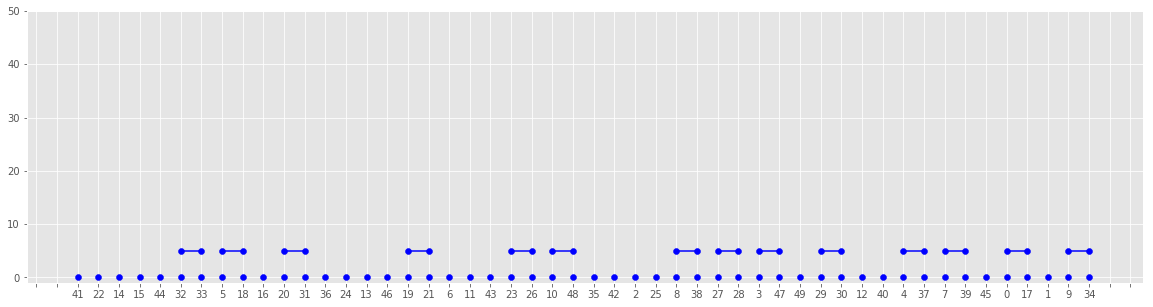

In [152]:
# насторойка тикера для дендрограмма - добавить

from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker

@ticker.FuncFormatter
def my_formatter(x, pos):
#     print (x, pos)
#     return pos
    _pos = int(x)

    if ((_pos < len(points)) & (_pos >=0)):
        #print(_pos, points[_pos])
        return points[(int(_pos))]
    else:
        #print(_pos)
        return ''

# Первый (нулевой) ряд
level = 0
points = []
for cl in сustum_aggl.treedict[level]:
    # print(cl.point_number)
    points.append(cl.point_number)
points_arr = np.array(points)

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 1, 1)

ax.xaxis.set_major_formatter(my_formatter)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_ylim(bottom=-1, top=50)
### ax.xaxis.set_minor_formatter(my_formatter)
ax.scatter(np.array(range(len(points_arr))), np.ones_like(points_arr) * level * 1, color='blue') 


# Попробуем нарисовать второй
level = 1
points_arr_prev = points_arr.copy()
for cl in сustum_aggl.treedict[1]:
    _litem, _ritem = cl.left.point_number, cl.right.point_number
    _lpos = np.argwhere(points_arr_prev == _litem)
    _rpos = np.argwhere(points_arr_prev == _ritem)
    # print(_lpos.flatten(), _rpos.flatten())
    ax.scatter(_lpos, level * 5, color='blue')
    ax.scatter(_rpos, level * 5, color='blue')
    ax.plot(np.concatenate([_lpos.flatten(), _rpos.flatten()]), np.ones([2]) * level * 5, color='blue')


# вычислить новые центры  

# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? Как еще учесть другую информацию о странице в расстоянии?

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках. В семинаре мы рассматривали более сложный вариант, но Вы сможете придумать лучше. 

In [3]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [4]:
import pandas as pd

In [5]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять например словами из тайтла

Главное подобрать хорошую функцию расстояния между документами

Удачи! Все получится!

Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

In [6]:
# Место для Вашего кластерного анализа

In [7]:
# поделим на группы
from collections import defaultdict

collections = []
for g in train_data.group_id.unique():
    titles = defaultdict(list)
    _df = train_data[train_data.group_id == g]
    for v in list(_df.doc_id.values):
        titles[v] = doc_to_title[v]
    collections.append((g, titles))

In [8]:
# сделаем несложную лемматизацию слов из заголовков
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
m = Mystem()
import re

russian_stopwords = stopwords.words("russian")

In [9]:
def tokenize(doc):
    tokens = nltk.tokenize.word_tokenize(doc)
    tokens_filt = []
    for t in tokens:

        # пока будем удалять токены с английскими буквами
        t = re.sub('[^А-Яа-я-\\n\\t]+', '', t)
        t = re.sub('[\\t\\n\\s]+', ' ', t)
        t = re.sub('[-]+', ' ', t)
        
        if t == ' ':
            continue
        if t == '':
            continue
        if t == '\n':
            continue
        if t == '-':
            continue
        if t == '•':
            continue
        if t == '\xa0':
            continue
            
        t = t.strip()

        t = t.replace('\xa0', ' ').replace('.', '').replace(',', '').lower()
        tlemm = m.lemmatize(t)
        tokens_filt.append(''.join(tlemm).replace('\n', ''))
        
    tokens_filt = [w for w in tokens_filt if w not in russian_stopwords]
    return tokens_filt

In [10]:
tokenize('веселого Васю в банку,,,,   ... и исчо пару слов ВАЗ-2109')

['веселый', 'вася', 'банка', 'исчо', 'пара', 'слово', 'ваз']

In [194]:
tkn_collections = []
united_dict = defaultdict(int)

for gid, corpus in collections:
    _dct = defaultdict(list)
    for k, v in corpus.items(): 
        terms = tokenize(v)
        _dct[k] = terms
        
        for t in terms:
            united_dict[t] += 1
        
    tkn_collections.append((gid, _dct))

In [200]:
# построили общий словарь
# возможно, есть смысл сделать отдельный словарь для каждой группы

# теперь сделаем частотный one hot vector, чтобы можно было измерять расстояния между заголовками 
# потом попробуем еще пофильтровать по частым словам

# прологарифмируем частоты
for k, v in united_dict.items():
    united_dict[k] = np.log(v)

In [201]:
words = list(united_dict.keys())

In [202]:
words_num_dict = {}
for pos, w in enumerate(words):
    words_num_dict[w] = pos 

In [423]:
vct_collections = []

for gid, corpus in tkn_collections:
    _dct = defaultdict(list)
    for k, v in corpus.items(): 
        # print(len(corpus.items()))
        terms = v
        vector = np.zeros([len(united_dict)])
        for t in terms:
            # print(t)
            if t in united_dict:
                vector[words_num_dict[t]] = 1 # 1 # make one hot instead of freq # united_dict[t]
        _dct[k] = vector
    vct_collections.append((gid, _dct))
    # print(vector)

In [436]:
# померяем качество
groups = train_data.group_id.unique()
scores = []

for gid in groups[:-1]:
    rows = []
    keys = []
    for k, v in vct_collections[gid][1].items():
        rows.append(v)
        keys.append(k)
    X_train = np.vstack(rows)

    clf = AgglomerativeClustering(n_clusters=2, linkage="ward", affinity='euclidean') # ward
    pred = clf.fit_predict(X_train)
    truth = train_data[train_data.apply(lambda x: (x.doc_id in keys) & (x.group_id == gid + 1), axis=1)].target.values
    scores.append(f1_score(truth, pred, average='micro'))

### F1-score (усреденный по группам)

In [437]:
np.array(scores).mean()

0.6553531647508424

Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

***Ваш ответ здесь***

Кластеризация подходит для всех задач (и, более того, незаменима), где необходимо найти структуру либо при отсутствии разметки по причине высокой стоимости, либо при отсутствии понимании структуры, т.е. когда её нужно сформировать на основе существующих данных - например, topic modeling для текстов, или поиск похожих профилей во временных рядах.

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

***Ваш ответ здесь***

<b>k-means</b> зависит от инициализации - можно считать недостатком, если пространство не высокой размерности, то вполне интерпретируем, простота - еще одно достоинство.
Но он бесполезен, когда кластеры линейно не разделимы (можно помочь kernel k-means, когда мы преобразуем пространство, в  котором осуществляем кластеризацию).

<b>dbscan</b> - удобен там, где нужно найти "плотные скопления" в пространстве, справляется с этим лучше других алгоритмов. Но не работает, если плотность кластеров разная. 

<b>Агломеративная (т.е. иерархическая) кластеризация</b> - наличие полной структуры кластеров - преимущество, высокая вычислителная сложность - недостаток.

* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

***Ваше ответ здесь***

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

***Ваше ответ здесь***
 
Признаки, построенные на частотности встречающихся в документах слов, как одиночных, так и частотных n-грамм (буквенные или словесные, смешанные - зависит от задачи), статистики по частям речи, соотношение слова в разных алфавитах, длина текста,  можно также попробовать word2vec, если существует релевантный w2vec для этого корпуска. Можно использовать LDA алгоритм для поиска тематик - недостаток - нужно самому подбирать количество тематик.

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

***Ваше ответ здесь***

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***

In [11]:
# Хотелось бы больше семинаров по темам математических основ ML.

Text(0,0.5,'Кластерное расстояние')

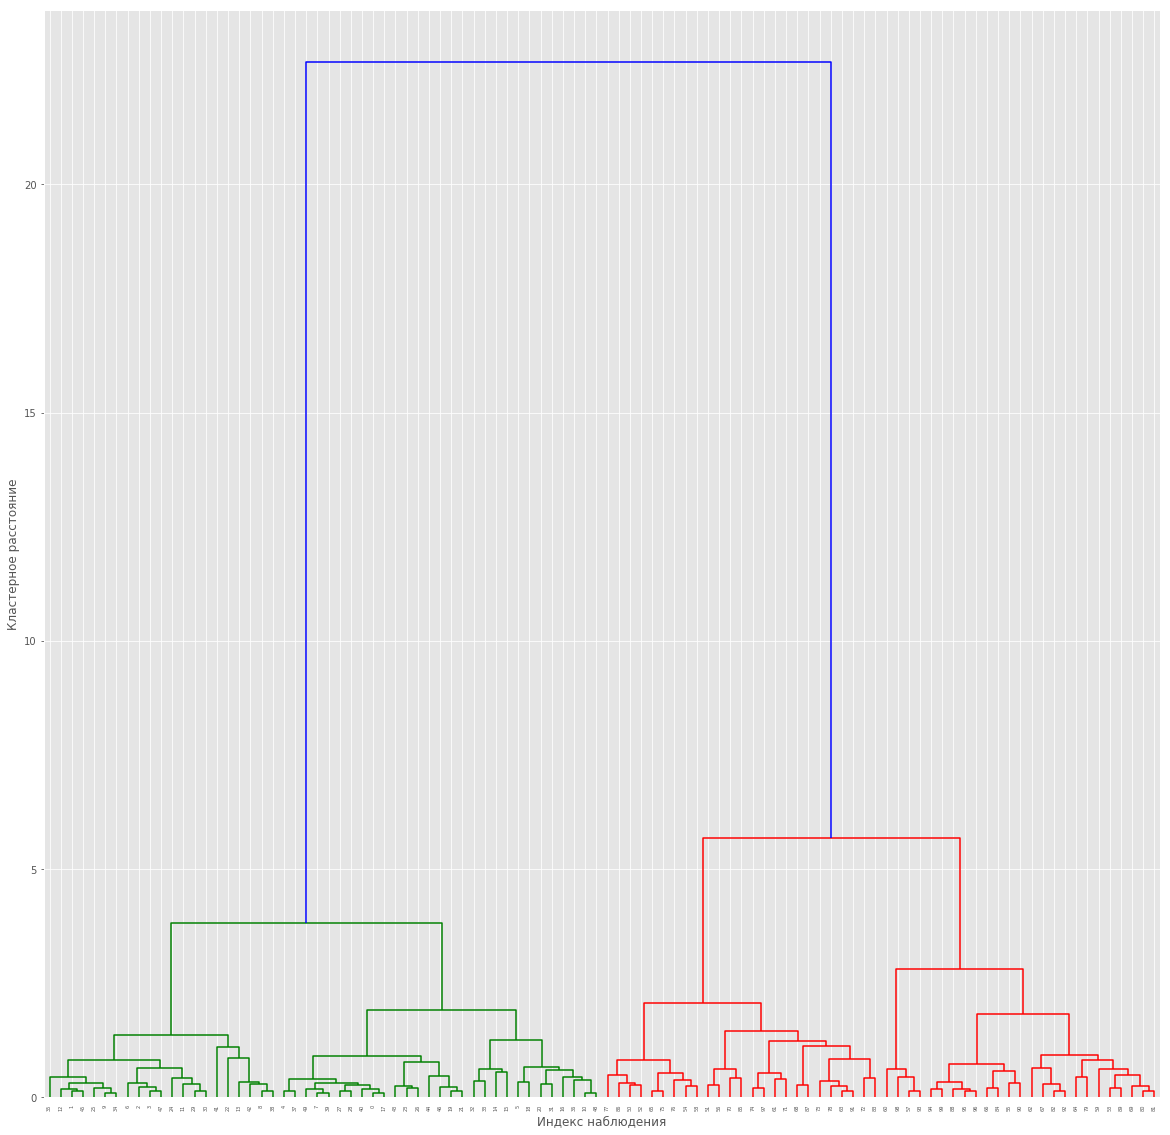

In [353]:
linkage_array = ward(x_iris)
dendrogram(linkage_array)
# делаем отметки на дереве, соответствующие двум или трем кластерам

ax = plt.gca()
bounds = ax.get_xbound()

plt.xlabel("Индекс наблюдения")
plt.ylabel("Кластерное расстояние")